In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from LIP_Model import PoseRefineNet, ParsingRefineNet, PoseNet, ParsingNet
from Model import BackboneResNet

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available else "cpu"

In [3]:
parsing_net = ParsingNet(20).to(device)
pose_net = PoseNet().to(device)
pose_refine = PoseRefineNet(20).to(device)
parsing_refine = ParsingRefineNet(20).to(device)
backbone = BackboneResNet().to(device)

In [4]:
backbone.load_state_dict(torch.load("parameters/backbone_parameter.pt"))
parsing_net.load_state_dict(torch.load("parameters/parsing_net_parameter.pt"))
parsing_refine.load_state_dict(torch.load("parameters/parsing_refine_net_parameter.pt"))
pose_net.load_state_dict(torch.load("parameters/pose_net_parameter.pt"))
pose_refine.load_state_dict(torch.load("parameters/pose_refine_net_parameter.pt"))

<All keys matched successfully>

In [5]:
# parsing_net = nn.DataParallel(parsing_net)
# pose_net = nn.DataParallel(pose_net)
# pose_refine = nn.DataParallel(pose_refine)
# parsing_refine = nn.DataParallel(parsing_refine)
# backbone = nn.DataParallel(backbone)

In [18]:
IMG_MEAN = np.array((104.00698793,116.66876762,122.67891434), dtype=np.float32)

class myTensor(object) :
    def __call__(self, pic) :
        if isinstance(pic, np.ndarray) :
            pass
        elif Image.isImageType(pic) :
            pic = np.array(pic)
            pic_r, pic_g, pic_b = np.split(pic, 3, axis=2)
            pic = np.concatenate([pic_b, pic_g, pic_r], axis=2)
            pic = pic - IMG_MEAN
            pic = torch.from_numpy(pic).permute(2,0,1)
            return pic
        else : # error
            pass

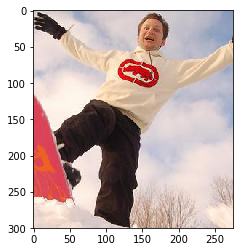

In [7]:
orig_img = Image.open("2583_462340.jpg")
plt.imshow(orig_img)

transform = transforms.Compose([myTensor()])
img = transform(orig_img)
orig_img_size = tuple(img.shape[1:])

transform_075 = transforms.Compose([transforms.Resize(tuple([int(t*0.75) for t in orig_img_size])),
                                    myTensor()])
img_075 = transform_075(orig_img)

transform_125 = transforms.Compose([transforms.Resize(tuple([int(t*1.25) for t in orig_img_size])),
                                    myTensor()])
img_125 = transform_125(orig_img)

In [8]:
img = img.unsqueeze(0)
img_reverse = torch.flip(img, dims=[2])
print(img.shape)

img_075 = img_075.unsqueeze(0)
img_075_reverse = torch.flip(img_075, dims=[2])
print(img_075.shape)

img_125 = img_125.unsqueeze(0)
img_125_reverse = torch.flip(img_125, dims=[2])
print(img_125.shape)

torch.Size([1, 3, 300, 275])
torch.Size([1, 3, 225, 206])
torch.Size([1, 3, 375, 343])


In [9]:
input_img = torch.cat((img,img_reverse), dim=0).to(device)
#input_img = img.to(device) # only use orig img

input_img_075 = torch.cat((img_075,img_075_reverse), dim=0).to(device)
input_img_125 = torch.cat((img_125,img_125_reverse), dim=0).to(device)

print(input_img.shape)

torch.Size([2, 3, 300, 275])


In [10]:
feature_map = backbone(input_img)

parsing_out1, parsing_fea1 = parsing_net(feature_map)
pose_map1, pose_context1 = pose_net(feature_map)

pose_map2, pose_context2 = pose_refine(pose_map1, parsing_out1, pose_context1)
parsing_out2, parsing_fea2 = parsing_refine(pose_map1, parsing_out1, parsing_fea1)
pose_map3, pose_context3 = pose_refine(pose_map2, parsing_out2, pose_context2)

In [11]:
feature_map_075 = backbone(input_img_075)

parsing_out1_075, parsing_fea1_075 = parsing_net(feature_map_075)
pose_map1_075, pose_context1_075 = pose_net(feature_map_075)

pose_map2_075, pose_context2_075 = pose_refine(pose_map1_075, parsing_out1_075, pose_context1_075)
parsing_out2_075, parsing_fea2_075 = parsing_refine(pose_map1_075, parsing_out1_075, parsing_fea1_075)
pose_map3_075, pose_context3_075 = pose_refine(pose_map2_075, parsing_out2_075, pose_context2_075)

In [12]:
feature_map_125 = backbone(input_img_125)

parsing_out1_125, parsing_fea1_125 = parsing_net(feature_map_125)
pose_map1_125, pose_context1_125 = pose_net(feature_map_125)

pose_map2_125, pose_context2_125 = pose_refine(pose_map1_125, parsing_out1_125, pose_context1_125)
parsing_out2_125, parsing_fea2_125 = parsing_refine(pose_map1_125, parsing_out1_125, parsing_fea1_125)
pose_map3_125, pose_context3_125 = pose_refine(pose_map2_125, parsing_out2_125, pose_context2_125)

In [13]:
pose_out = torch.mean(torch.stack((nn.functional.interpolate(pose_map3, size=orig_img_size),
                                     nn.functional.interpolate(pose_map3_075, size=orig_img_size),
                                     nn.functional.interpolate(pose_map3_125, size=orig_img_size))), dim=0)

head_output, tail_output = torch.unbind(pose_out, dim=0)
tail_list = torch.unbind(tail_output, dim=0)

In [14]:
tail_list_rev = [None] * 16
tail_list_rev[0] = tail_list[5]
tail_list_rev[1] = tail_list[4]
tail_list_rev[2] = tail_list[3]
tail_list_rev[3] = tail_list[2]
tail_list_rev[4] = tail_list[1]
tail_list_rev[5] = tail_list[0]
tail_list_rev[10] = tail_list[15]
tail_list_rev[11] = tail_list[14]
tail_list_rev[12] = tail_list[13]
tail_list_rev[13] = tail_list[12]
tail_list_rev[14] = tail_list[11]
tail_list_rev[15] = tail_list[10]
tail_list_rev[6] = tail_list[6]
tail_list_rev[7] = tail_list[7]
tail_list_rev[8] = tail_list[8]
tail_list_rev[9] = tail_list[9]

In [15]:
tail_output_rev = torch.stack(tail_list_rev, dim=0)

output_all = torch.mean(torch.stack((head_output, tail_output_rev)), dim=0, keepdim=True)

109 299
197 288
121 123
209 97
196 299
45 288
170 81
219 13
163 55
43 210
258 113
113 154
229 6
248 13
78 117
58 210


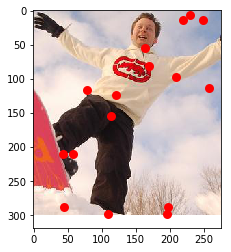

In [16]:
plt.imshow(orig_img)

for c in range(output_all.shape[1]) :
    channel = output_all[0][c]
    x, y = np.unravel_index(channel.cpu().argmax(), channel.shape)
    plt.scatter(y, x, linewidths=3, c="red")
    print(y, x)

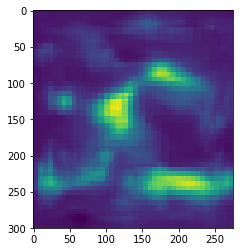

In [17]:
plt.imshow(output_all[0][2].cpu().detach().numpy())